In [1]:
!pip install category_encoders --quiet


In [2]:
import warnings
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # split the neighborhoodabs
    df["neighborhood"]=df["place_with_parent_names"].str.split("|",expand=True)[3]
    df.drop(columns="place_with_parent_names",inplace=True)

    return df

In [4]:
files=glob(r"C:\Users\educa\Downloads\Buenos data\buenos-aires-real-estate-*.csv")
files

['C:\\Users\\educa\\Downloads\\Buenos data\\buenos-aires-real-estate-1.csv',
 'C:\\Users\\educa\\Downloads\\Buenos data\\buenos-aires-real-estate-2.csv',
 'C:\\Users\\educa\\Downloads\\Buenos data\\buenos-aires-real-estate-3.csv',
 'C:\\Users\\educa\\Downloads\\Buenos data\\buenos-aires-real-estate-4.csv',
 'C:\\Users\\educa\\Downloads\\Buenos data\\buenos-aires-real-estate-5.csv']

In [5]:
frames=[]
for file in files:
    df=wrangle(file)
    frames.append(df)
    

In [6]:
frames[0].head()

,operation,property_type,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon,neighborhood
4,sell,apartment,129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...,-34.584651,-58.454693,Chacarita
9,sell,apartment,87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...,-34.638979,-58.500115,Villa Luro
29,sell,apartment,118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...,-34.615847,-58.459957,Caballito
40,sell,apartment,57000.0,USD,864256.8,57000.0,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364.0,http://constitucion.properati.com.ar/k2f0_vent...,-34.625222,-58.382382,Constitución
41,sell,apartment,90000.0,USD,1364616.0,90000.0,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450.0,http://once.properati.com.ar/suwa_venta_depart...,-34.610610,-58.412511,Once


In [7]:
df=pd.concat(frames,ignore_index=True)
df

,operation,property_type,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon,neighborhood
0,sell,apartment,129000.0,USD,1955949.60,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...,-34.584651,-58.454693,Chacarita
1,sell,apartment,87000.0,USD,1319128.80,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...,-34.638979,-58.500115,Villa Luro
2,sell,apartment,118000.0,USD,1789163.20,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...,-34.615847,-58.459957,Caballito
3,sell,apartment,57000.0,USD,864256.80,57000.0,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364.0,http://constitucion.properati.com.ar/k2f0_vent...,-34.625222,-58.382382,Constitución
4,sell,apartment,90000.0,USD,1364616.00,90000.0,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450.0,http://once.properati.com.ar/suwa_venta_depart...,-34.610610,-58.412511,Once
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6577,sell,apartment,290000.0,USD,4397096.00,290000.0,93.0,83.0,3118.279570,3493.975904,NaN,4.0,NaN,http://liniers.properati.com.ar/t11h_venta_dep...,-34.639528,-58.519666,Liniers
6578,sell,apartment,150000.0,USD,2274360.00,150000.0,92.0,45.0,1630.434783,3333.333333,NaN,1.0,1000.0,http://palermo.properati.com.ar/zowv_venta_dep...,-34.597825,-58.416439,Palermo
6579,sell,apartment,65000.0,USD,985556.00,65000.0,42.0,42.0,1547.619048,1547.619048,NaN,2.0,1000.0,http://mataderos.properati.com.ar/11zcp_venta_...,-34.652233,-58.490739,Mataderos
6580,sell,apartment,91440.0,USD,1386449.85,91440.0,NaN,48.0,NaN,1905.000000,6.0,2.0,NaN,http://mataderos.properati.com.ar/xlo5_venta_d...,-34.648761,-58.500180,Mataderos


In [8]:
target='price_aprox_usd'
features=['neighborhood']
X_train=df[features]
y_train=df[target]

## Baseline

In [9]:
y_mean=y_train.mean()
y_pred_baseline=[y_mean]*len(y_train)

print("Mean apt price:", y_mean)
print("Baseline MAE:", mean_absolute_error(y_train,y_pred_baseline))

Mean apt price: 132383.83701458524
Baseline MAE: 44860.10834274133


In [10]:
# instantiate
ohe=OneHotEncoder(use_cat_names=True)
# fit
ohe.fit(X_train)
# transform 
XT_train=ohe.transform(X_train)
print(XT_train.shape)
XT_train.head()

(6582, 57)


,neighborhood_Chacarita,neighborhood_Villa Luro,neighborhood_Caballito,neighborhood_Constitución,neighborhood_Once,neighborhood_Almagro,neighborhood_Palermo,neighborhood_Flores,neighborhood_Belgrano,neighborhood_Liniers,...,neighborhood_Puerto Madero,neighborhood_Agronomía,neighborhood_Monte Castro,neighborhood_Tribunales,neighborhood_Villa Santa Rita,neighborhood_Velez Sarsfield,neighborhood_Villa Soldati,neighborhood_Villa Real,neighborhood_Pompeya,neighborhood_Catalinas
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
model=make_pipeline(
    OneHotEncoder(use_cat_names=True),
    Ridge()
)
model.fit(X_train,y_train)

,steps,"[('onehotencoder', ...), ('ridge', ...)]"
,transform_input,None
,memory,None
,verbose,False
,verbose,0
,cols,['neighborhood']
,drop_invariant,False
,return_df,True
,handle_missing,'value'
,handle_unknown,'value'
,use_cat_names,True


In [12]:
y_pred_training=model.predict(X_train)
mae_pred_training=mean_absolute_error(y_train,y_pred_training)
print("Training MAE:", round(mae_pred_training, 2))

Training MAE: 39339.72


In [26]:
intercept = model.named_steps['ridge'].intercept_
coefficients = model.named_steps['ridge'].coef_
print("coefficients len:", len(coefficients))
print(coefficients[:5])  # First five coefficients
print('intercept:',intercept)

coefficients len: 57
[-2.89895934e+03 -6.29555347e+00  9.25289088e+03 -4.17487330e+04
 -3.23037446e+03]
intercept: 118524.64732064676


yes we have value of our coefficient but how do we know the features that they correspond to ?

## Extract the feature names 

In [27]:
feature_names = model.named_steps["onehotencoder"].get_feature_names()
print("features len:", len(feature_names))
print(feature_names[:5])  # First five feature names

features len: 57
['neighborhood_Chacarita' 'neighborhood_Villa Luro'
 'neighborhood_Caballito' 'neighborhood_Constitución' 'neighborhood_Once']


In [28]:
feat_imp = pd.Series(coefficients,index=feature_names)
feat_imp.head()

neighborhood_Chacarita       -2898.959335
neighborhood_Villa Luro         -6.295553
neighborhood_Caballito        9252.890876
neighborhood_Constitución   -41748.733031
neighborhood_Once            -3230.374461
dtype: float64

In [29]:
print(f"price = {intercept.round(2)}")
for f, c in feat_imp.items():
    print(f"+ ({round(c, 2)} * {f})")

price = 118524.65
+ (-2898.96 * neighborhood_Chacarita)
+ (-6.3 * neighborhood_Villa Luro)
+ (9252.89 * neighborhood_Caballito)
+ (-41748.73 * neighborhood_Constitución)
+ (-3230.37 * neighborhood_Once)
+ (2903.34 * neighborhood_Almagro)
+ (45934.41 * neighborhood_Palermo)
+ (-8662.28 * neighborhood_Flores)
+ (46954.21 * neighborhood_Belgrano)
+ (-13729.1 * neighborhood_Liniers)
+ (6277.05 * neighborhood_Villa Crespo)
+ (-10678.63 * neighborhood_San Cristobal)
+ (-7974.66 * neighborhood_Congreso)
+ (14701.16 * neighborhood_Saavedra)
+ (-11172.55 * neighborhood_Balvanera)
+ (-29585.61 * neighborhood_Parque Avellaneda)
+ (72740.78 * neighborhood_Recoleta)
+ (5638.47 * neighborhood_San Telmo)
+ (42831.32 * neighborhood_Nuñez)
+ (55590.93 * neighborhood_Barrio Norte)
+ (-6323.68 * neighborhood_Parque Centenario)
+ (4330.55 * neighborhood_Abasto)
+ (-7905.29 * neighborhood_Centro / Microcentro)
+ (-19370.74 * neighborhood_)
+ (-7108.23 * neighborhood_Paternal)
+ (-21078.78 * neighborhood_Ma

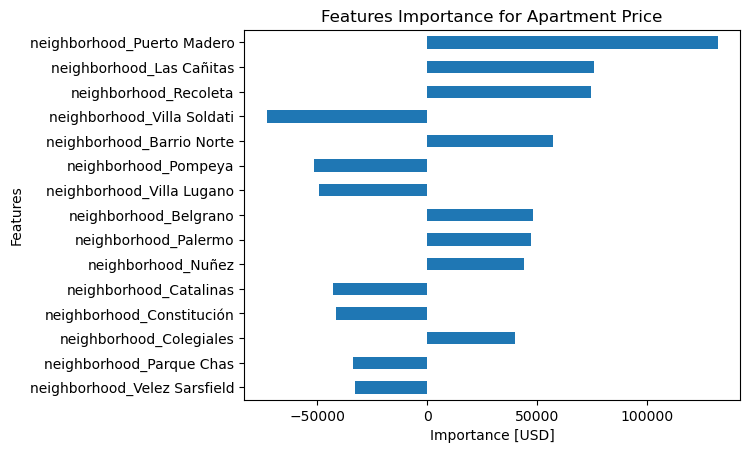

In [24]:
feat_imp.sort_values(key=abs).tail(15).plot(kind='barh')
plt.xlabel('Importance [USD]')
plt.ylabel('Features')
plt.title('Features Importance for Apartment Price');